# REINFORCE on CartPole-v0

In [ ]:
# Download necessary libraries for the gym env and showing videos function
!pip install pyglet
!apt-get install -y xvfb python-opengl x11-utils
!pip install gym==0.17.2 pyvirtualdisplay==0.2.5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  libgle3 mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 python-opengl x11-utils xvfb
0 upgraded, 4 newly installed, 0 to remove and 42 not upgraded.
Need to get 1,490 kB of archives.
After this operation, 8,398 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:

In [ ]:
#Make necessary imports
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.distributions import Categorical
torch.manual_seed(0)

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
from gym import logger as gymlogger
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import random
import glob
import io
import time
import base64

display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Instantiate the Environment and Agent

CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space. 

In [ ]:
env = gym.make('CartPole-v0')

# Policy gradient has high variance, seed for reproducability
env.seed(0)

n_actions = env.action_space.n
state_dim = env.observation_space.shape

print('The original number of state features: {}'.format(state_dim))
print('Number of possible actions: {}'.format(n_actions))

The original number of state features: (4,)
Number of possible actions: 2


In [ ]:
# Initialise the cartpole environment
observation = env.reset()
frames = []
for t in range(1000):
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break

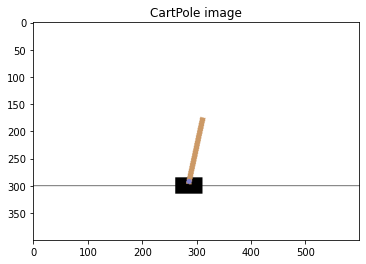

In [ ]:
# review CartPole image
plt.title("CartPole image")
plt.imshow(env.render("rgb_array"))
plt.show()

### Define Policy Network
Unlike value-based method, the output of policy-based method is the probability of each action. It can be represented as policy. So activation function of output layer will be softmax, not ReLU.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)
    
    # Select Action
    def action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

### REINFORCE

In [ ]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.action(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # Calculate the loss 
        policy_loss = []

        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)

        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        # Print the result every 100 steps
        if e % print_every == 0:
            print("==========================================")
            print("Episode: ", e , "/", n_episodes)
            print('Average Score: {:.2f}'.format(np.mean(scores_deque)))
        # Terminate the training process once the average score is greater and equal to 195
        if np.mean(scores_deque) >= 195.0:
            print("==========================================")
            print("Stopping at episode {} with average rewards of {}.".format(e - 100, np.mean(scores_deque)))
            break
    return scores

### Run

In [ ]:
# Hyperparameters
n_episodes = 5000
max_t = 1000
gamma = 0.95
print_every = 100
learning_rate = 1e-2

In [ ]:
# Create a Policy Network
policy = PolicyNetwork(state_dim=4, n_actions=2, hidden_size=32).to(device)

# We use Adam optimiser in this case
optimizer = optim.Adam(policy.parameters(), learning_rate)

In [ ]:
# Run the policy gradient approach and obtain the scores
scores = reinforce(policy, optimizer, n_episodes, max_t, gamma, print_every)

Episode:  100 / 5000
Average Score: 13.30
Episode:  200 / 5000
Average Score: 38.06
Episode:  300 / 5000
Average Score: 40.40
Episode:  400 / 5000
Average Score: 41.84
Episode:  500 / 5000
Average Score: 67.87
Episode:  600 / 5000
Average Score: 54.62
Episode:  700 / 5000
Average Score: 53.80
Episode:  800 / 5000
Average Score: 52.73
Episode:  900 / 5000
Average Score: 17.01
Episode:  1000 / 5000
Average Score: 11.24
Episode:  1100 / 5000
Average Score: 16.38
Episode:  1200 / 5000
Average Score: 21.22
Episode:  1300 / 5000
Average Score: 48.19
Episode:  1400 / 5000
Average Score: 57.67
Episode:  1500 / 5000
Average Score: 44.44
Episode:  1600 / 5000
Average Score: 31.00
Episode:  1700 / 5000
Average Score: 28.59
Episode:  1800 / 5000
Average Score: 45.63
Episode:  1900 / 5000
Average Score: 57.26
Episode:  2000 / 5000
Average Score: 56.38
Episode:  2100 / 5000
Average Score: 21.04
Episode:  2200 / 5000
Average Score: 11.82
Episode:  2300 / 5000
Average Score: 49.87
Episode:  2400 / 500

### Plot the learning progress

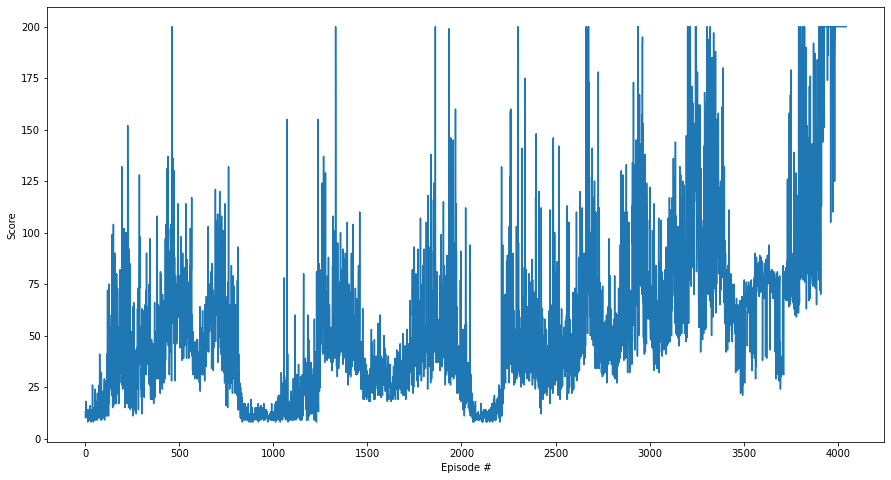

In [ ]:
# Optimiser is Adam
# plot the total rewards versus number of episodes 
plt.rcParams['figure.figsize'] = (15, 8)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [ ]:
def show_video():
  """Enables video recording of gym environment and shows it."""
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Video not found")

def wrap_environment(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
# Wrap the environment by using Monitor
env = gym.make("CartPole-v0")
env = wrap_environment(env)
state = env.reset()
ep_rew, done = 0, False

for t in range(10000):
  action, _ = policy.action(state)
  next_state, reward, done, _ = env.step(action)
  state = next_state
  ep_rew += reward
  if done:
    break
print(f'Total Return: {ep_rew}')
env.close()
show_video()

Total Return: 200.0


### Explore the impact of varying hyperparameter(s).

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)
    
    # Select Action
    def action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [ ]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.action(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # Calculate the loss 
        policy_loss = []

        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)

        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        # Terminate the training process once the average scores are greater and equal to 195
        if np.mean(scores_deque) >= 195.0:
            print("==========================================")
            print("Stopping at episode {} with average rewards of {}.".format(e - 100, np.mean(scores_deque)))
            break
    return scores, np.mean(scores_deque)

In [ ]:
# Hyperparameters
n_episodes = 5000
max_t = 1000
print_every=100
learning_rate = 1e-2

In [ ]:
# Create a Policy Network
policy = PolicyNetwork(state_dim=4, n_actions=2, hidden_size=32).to(device)

# We use Adam optimiser in this case
optimizer = optim.Adam(policy.parameters(), learning_rate)

In [ ]:
# Initialise a reward list for different gamma
different_rewards = []

# Discount factor = 0.85

gamma = 0.85
print('Discount factor =', gamma)
scores, average = reinforce(policy, optimizer, n_episodes, max_t, gamma, print_every)
print("Rewards =",average)
# save the scores inside the list
different_rewards.append(scores)

Discount factor = 0.85
Rewards = 9.27


In [ ]:
# Discount factor = 0.9

gamma = 0.9
print('Discount factor =', gamma)
scores, average = reinforce(policy, optimizer, n_episodes, max_t, gamma, print_every)
print("Rewards =",average)
# save the scores inside the list
different_rewards.append(scores)

Discount factor = 0.9
Rewards = 12.21


In [ ]:
# Discount factor = 0.925

gamma = 0.925
print('Discount factor =', gamma)
scores, average = reinforce(policy, optimizer, n_episodes, max_t, gamma, print_every)
print("Rewards =",average)
# save the scores inside the list
different_rewards.append(scores)

Discount factor = 0.925
Rewards = 40.41


In [ ]:
# Discount factor = 0.95

gamma = 0.95
print('Discount factor =', gamma)
scores, average = reinforce(policy, optimizer, n_episodes, max_t, gamma, print_every)
print("Rewards =",average)
# save the scores inside the list
different_rewards.append(scores)

Discount factor = 0.95
Rewards = 78.36


In [ ]:
# Discount factor = 0.975

gamma = 0.975
print('Discount factor =', gamma)
scores, average = reinforce(policy, optimizer, n_episodes, max_t, gamma, print_every)
print("Rewards =",average)
# save the scores inside the list
different_rewards.append(scores)

Discount factor = 0.975
Rewards = 64.6


In [ ]:
# Discount factor = 0.995

gamma = 0.995
print('Discount factor =', gamma)
scores, average = reinforce(policy, optimizer, n_episodes, max_t, gamma, print_every)
print("Rewards =",average)
# save the scores inside the list
different_rewards.append(scores)

Discount factor = 0.995
Rewards = 67.14


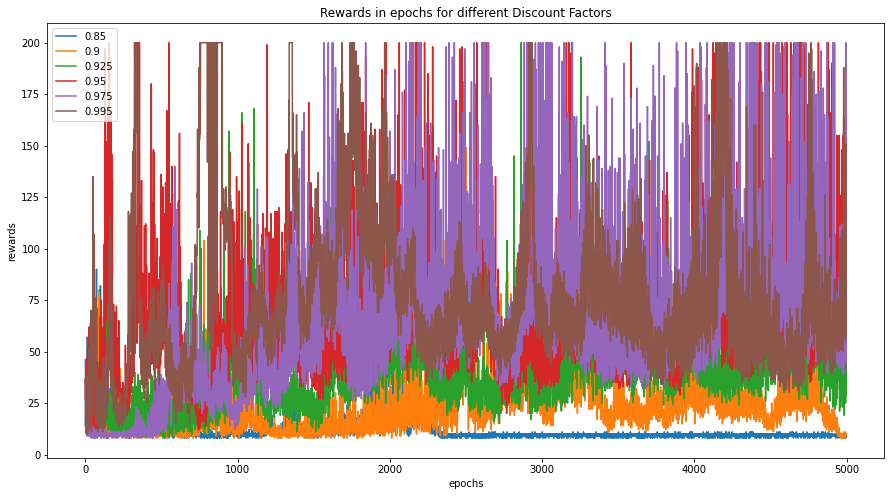

In [ ]:
# Create a list with different value of gammas for visualisation
gammas = [0.85, 0.9, 0.925, 0.95, 0.975, 0.995]

# Plot the graph
plt.figure(figsize=(15,8))
for df, reward_epoch in zip(gammas,different_rewards):
    plt.plot(reward_epoch, label=df)
plt.title('Rewards in epochs for different Discount Factors')
plt.xlabel('epochs'), plt.ylabel('rewards')
plt.legend()
plt.show()